In [1]:
# imports
import pathlib, pickle
import sqlalchemy as sqa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# read the credentials from the pickle file
db_auth_pkl_file_path = pathlib.Path("/home/neminiz1/flyer_analysis_db_auth.pkl")
with open(db_auth_pkl_file_path, "rb") as fp:
    auth = pickle.load(fp)

# connect to the database with an engine and reflect it onto a metadata object
db_connection_string = (
    f"mssql+pymssql://{auth['username']}:{auth['password']}"
    f"@{auth['ip_address']}:{auth['port']}/{auth['db_name']}?charset=utf8"
)
engine = sqa.create_engine(db_connection_string)  # ,echo=True)
meta = sqa.MetaData()
meta.reflect(bind=engine)

### Find all of the tables in the DB and each table's column names

In [3]:
for table in meta.tables:
    print(f"-------{table} table----------")
    table_pks = [
        key.name for key in sqa.inspection.inspect(meta.tables[table]).primary_key
    ]
    for column in meta.tables[table].columns:
        prepend = "PRIMARY KEY: " if column.name in table_pks else ""
        foreign_keys = [
            f"FK: {key.target_fullname}"
            for key in meta.tables[table].columns[column.name].foreign_keys
        ]
        append = f" ({','.join(foreign_keys)})" if len(foreign_keys) > 0 else ""
        print(f"\t{prepend}{column}{append}")

-------epoxy table----------
	epoxy.epoxy_id
	PRIMARY KEY: epoxy.epoxy_name
	epoxy.description
	epoxy.epoxy_supplier
	epoxy.recordid
-------experiment table----------
	experiment.performed_by
	experiment.date
	experiment.energy
	experiment.theoretical_beam_diameter
	experiment.fluence
	experiment.beam_shaper_input_beam_diameter
	experiment.beam_shaper
	experiment.effective_focal_length
	experiment.drive_laser_mode
	experiment.oscillator_setting
	experiment.amplifier_setting
	experiment.attenuator_angle
	experiment.new_energy_measurement
	experiment.booster_amp_setting
	experiment.preamp_output_power
	experiment.pdv_spot_size
	experiment.focusing_lens_arrangement
	experiment.system_configuration
	experiment.current_set_point
	experiment.oscilloscope_range
	experiment.pdv_method
	experiment.seed_laser_wavelength
	experiment.reference_laser_wavelength
	experiment.time_per_div
	experiment.carrier_freq
	experiment.camera_lens
	experiment.doubler
	experiment.camera_aperture
	experiment.lens_

### Plotting the dates of every experiment

In [4]:
with engine.connect() as conn:
    min_date = conn.execute(sqa.text("SELECT MIN(date) FROM experiment")).first()[0]

with engine.connect() as conn:
    max_date = conn.execute(sqa.text("SELECT MAX(date) FROM experiment")).first()[0]

with engine.connect() as conn:
    results = conn.execute(sqa.text("SELECT date, performed_by FROM experiment")).all()

In [5]:
experiment_dates_for_performer = {}
for res in results:
    if res.performed_by not in experiment_dates_for_performer:
        experiment_dates_for_performer[res.performed_by] = []
    experiment_dates_for_performer[res.performed_by].append(res.date)

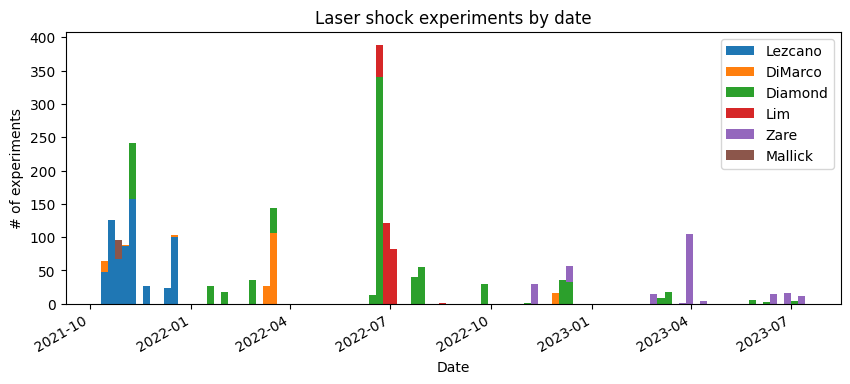

In [6]:
f, ax = plt.subplots(figsize=(10.0, 4.0))
ax.hist(
    experiment_dates_for_performer.values(),
    bins=100,
    range=(min_date, max_date),
    label=list(experiment_dates_for_performer.keys()),
    stacked=True,
)
ax.legend(loc="best")
ax.set_xlabel("Date")
ax.set_ylabel("# of experiments")
ax.set_title("Laser shock experiments by date")
f.autofmt_xdate()
plt.show()

### Getting the numbers of experiments performed on each sample and their date ranges

In [7]:
query = """
    SELECT experiment.date, sample.sample_name
    FROM experiment
    JOIN launch_package ON experiment.launch_id = launch_package.launch_id
    JOIN sample ON launch_package.sample_name = sample.sample_name
"""

with engine.connect() as conn:
    results = conn.execute(sqa.text(query)).all()

In [8]:
experiment_dates_for_sample = {}
for res in results:
    if res.sample_name not in experiment_dates_for_sample:
        experiment_dates_for_sample[res.sample_name] = []
    experiment_dates_for_sample[res.sample_name].append(res.date)

In [9]:
display_df = pd.DataFrame.from_dict(
    {
        "sample name": list(experiment_dates_for_sample.keys()),
        "earliest experiment": [
            min(exp_date_list) for exp_date_list in experiment_dates_for_sample.values()
        ],
        "latest experiment": [
            max(exp_date_list) for exp_date_list in experiment_dates_for_sample.values()
        ],
    }
)

display_df.sort_values("earliest experiment", inplace=True)

print(display_df.to_string())

                               sample name earliest experiment latest experiment
2             20-26 Mg-6Al 4Bc ECAE Billet          2021-10-13        2021-10-20
3             20-25 Mg-6Al 4Bc ECAE Billet          2021-10-19        2021-10-21
1              22-04 Mg-6Al 4Bc ECAE Plate          2021-10-21        2021-11-12
11                          Suhas20211027D          2021-10-28        2021-10-28
8                           Suhas20211027A          2021-10-28        2022-03-18
9                           Suhas20211027B          2021-10-28        2022-03-18
10                          Suhas20211027C          2021-10-28        2021-10-28
6          22-17 Mg-6Al 1Bc+3Bc ECAE Plate          2021-11-03        2021-11-12
7              23-03 Mg-9Al 4Bc ECAE Plate          2021-11-03        2021-11-12
12     Jenna Sample1 MgZnCa ECAE 5um grain          2021-11-09        2022-01-28
5     Jenna Sample2 MgZnCa ECAE 20um grain          2021-11-11        2022-06-22
16             Lexan 8010 12

### Finding the experiments that have video analysis data

In [10]:
with engine.connect() as conn:
    metadata_links_df = pd.read_sql("SELECT * FROM metadata_links",conn)

print(metadata_links_df.to_string())

        ID  datestamp experiment_day_counter camera_filename
0        1 2023-06-16                  00000            None
1        2        NaT                   None        15_21_08
2        3 2023-06-16                  00001            None
3        4 2021-11-09                   None        21_19_38
4        5 2021-12-17                   None        14_05_23
5        6 2022-02-18                   None        16_23_55
6        7 2022-02-18                   None        17_24_11
7        8 2022-03-10                   None        11_31_51
8        9 2022-03-10                   None        11_59_17
9       10 2022-03-10                   None        12_04_06
10      11 2022-03-10                   None        13_40_01
11      12 2022-03-10                   None        13_43_50
12      13 2022-03-10                   None        13_47_12
13      14 2022-03-10                   None        13_50_21
14      15 2022-03-10                   None        14_22_56
15      16 2022-03-10   